In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import json
import nltk
import re
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/josephchang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/josephchang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/josephchang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/josephchang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Import

In [2]:
# read in the data
df = pd.read_csv('/Users/josephchang/combined.txt', low_memory = False)
df

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5.0,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1.0,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,5.0,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,5.0,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
749399,4.0,True,"04 26, 2017",ADM1SE5Y1O2W8,B01HJ7JP6G,{'Color:': ' 20 color'},Christine Beutner,What's not to love? The price. Watercolor pens...,Four Stars,1493164800,NaN,NaN
749400,5.0,True,"02 12, 2017",A3EFXAHEUYT0J7,B01HJ7JP6G,{'Color:': ' 20 color'},connie swant,lots of color in these markers,Five Stars,1486857600,NaN,NaN
749401,5.0,True,"01 22, 2017",A1LQOTRLG8TJKB,B01HJ7JP6G,{'Color:': ' 20 color'},Rachel,These are really fun to use. I love watercolor...,Very cool watercolor pens,1485043200,NaN,NaN
749402,1.0,True,"01 20, 2018",AG9G5RUY6IZMK,B01HJBWFBO,NaN,One woman,"While the box says vibrant colors, only a few ...",So little pigment the color barely shows,1516406400,NaN,NaN


# Data Cleaning

In [3]:
# drop duplicate rows
df1 = df.drop_duplicates()

# keep the columns that are needed
df1 = df[['overall', 'verified', 'reviewText', 'summary']]

# drop null values
df1.dropna(inplace = True)
df1

,overall,verified,reviewText,summary
0,5.0,True,As advertised. Reasonably priced,Five Stars
1,5.0,True,Like the oder and the feel when I put it on my...,Good for the face
2,1.0,True,I bought this to smell nice after I shave. Wh...,Smells awful
3,5.0,False,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.
4,5.0,True,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo
...,...,...,...,...
749399,4.0,True,What's not to love? The price. Watercolor pens...,Four Stars
749400,5.0,True,lots of color in these markers,Five Stars
749401,5.0,True,These are really fun to use. I love watercolor...,Very cool watercolor pens
749402,1.0,True,"While the box says vibrant colors, only a few ...",So little pigment the color barely shows


In [4]:
# filter dataframe to look at frequency of values in 'verified' column
df1['verified'].value_counts()

True     685837
False     63032
Name: verified, dtype: int64

In [5]:
# remove the unverified rows
df1 = df1[df1['verified'] == True]
df1

,overall,verified,reviewText,summary
0,5.0,True,As advertised. Reasonably priced,Five Stars
1,5.0,True,Like the oder and the feel when I put it on my...,Good for the face
2,1.0,True,I bought this to smell nice after I shave. Wh...,Smells awful
4,5.0,True,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo
7,2.0,True,No change my scalp still itches like crazy. It...,No change my scalp still itches like crazy. It...
...,...,...,...,...
749399,4.0,True,What's not to love? The price. Watercolor pens...,Four Stars
749400,5.0,True,lots of color in these markers,Five Stars
749401,5.0,True,These are really fun to use. I love watercolor...,Very cool watercolor pens
749402,1.0,True,"While the box says vibrant colors, only a few ...",So little pigment the color barely shows


In [6]:
# create the sentiment column for binary models
df1["sentiment"] = df1["overall"].apply(lambda x: 1 if x > 3 else -1 if x < 3 else 0)
df1

,overall,verified,reviewText,summary,sentiment
0,5.0,True,As advertised. Reasonably priced,Five Stars,1
1,5.0,True,Like the oder and the feel when I put it on my...,Good for the face,1
2,1.0,True,I bought this to smell nice after I shave. Wh...,Smells awful,-1
4,5.0,True,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1
7,2.0,True,No change my scalp still itches like crazy. It...,No change my scalp still itches like crazy. It...,-1
...,...,...,...,...,...
749399,4.0,True,What's not to love? The price. Watercolor pens...,Four Stars,1
749400,5.0,True,lots of color in these markers,Five Stars,1
749401,5.0,True,These are really fun to use. I love watercolor...,Very cool watercolor pens,1
749402,1.0,True,"While the box says vibrant colors, only a few ...",So little pigment the color barely shows,-1


In [7]:
# set the correct mapping for the 'overall' column
mapping = {1: 0, 2: 0, 3: 1, 4: 2, 5: 2}
df1['new_overall'] = df1['overall'].map(mapping)
df1

,overall,verified,reviewText,summary,sentiment,new_overall
0,5.0,True,As advertised. Reasonably priced,Five Stars,1,2
1,5.0,True,Like the oder and the feel when I put it on my...,Good for the face,1,2
2,1.0,True,I bought this to smell nice after I shave. Wh...,Smells awful,-1,0
4,5.0,True,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1,2
7,2.0,True,No change my scalp still itches like crazy. It...,No change my scalp still itches like crazy. It...,-1,0
...,...,...,...,...,...,...
749399,4.0,True,What's not to love? The price. Watercolor pens...,Four Stars,1,2
749400,5.0,True,lots of color in these markers,Five Stars,1,2
749401,5.0,True,These are really fun to use. I love watercolor...,Very cool watercolor pens,1,2
749402,1.0,True,"While the box says vibrant colors, only a few ...",So little pigment the color barely shows,-1,0


In [8]:
# combine the 'reviewText' column with 'summary'
df1['reviewTextSummary'] = df1['reviewText'] + " " + df1['summary']
df1.head()

,overall,verified,reviewText,summary,sentiment,new_overall,reviewTextSummary
0,5.0,True,As advertised. Reasonably priced,Five Stars,1,2,As advertised. Reasonably priced Five Stars
1,5.0,True,Like the oder and the feel when I put it on my...,Good for the face,1,2,Like the oder and the feel when I put it on my...
2,1.0,True,I bought this to smell nice after I shave. Wh...,Smells awful,-1,0,I bought this to smell nice after I shave. Wh...
4,5.0,True,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1,2,If you ever want to feel pampered by a shampoo...
7,2.0,True,No change my scalp still itches like crazy. It...,No change my scalp still itches like crazy. It...,-1,0,No change my scalp still itches like crazy. It...


In [9]:
# remove the 'reviewText' and 'summary' columns
df2 = df1.drop(['reviewText', 'summary', 'overall'], axis=1)
df2


,verified,sentiment,new_overall,reviewTextSummary
0,True,1,2,As advertised. Reasonably priced Five Stars
1,True,1,2,Like the oder and the feel when I put it on my...
2,True,-1,0,I bought this to smell nice after I shave. Wh...
4,True,1,2,If you ever want to feel pampered by a shampoo...
7,True,-1,0,No change my scalp still itches like crazy. It...
...,...,...,...,...
749399,True,1,2,What's not to love? The price. Watercolor pens...
749400,True,1,2,lots of color in these markers Five Stars
749401,True,1,2,These are really fun to use. I love watercolor...
749402,True,-1,0,"While the box says vibrant colors, only a few ..."


In [10]:
# make sure there is no missing values
missing_values = df2['reviewTextSummary'].isnull().sum()
missing_values

0

# Data Preprocessing

In [11]:
stop_word_group = stopwords.words('english')

lematizer = WordNetLemmatizer()

def preprocess_text(textblob):
    textblob = re.sub(r'\d', '', textblob, re.UNICODE)
    textblob = re.sub(r'[^\w\s]', '', textblob, re.UNICODE)
    textblob = textblob.lower()
    textblob = [lematizer.lemmatize(token) for token in textblob.split(" ")]
    textblob = [word for word in textblob if not word in stop_word_group] # removing any stopwords 
    textblob = " ".join(textblob)
    return textblob

df2['reviewTextSummary'] = df2.reviewTextSummary.apply(lambda x: preprocess_text(x))
df2

,verified,sentiment,new_overall,reviewTextSummary
0,True,1,2,advertised reasonably priced five star
1,True,1,2,like oder feel put face tried brand review pe...
2,True,-1,0,bought smell nice shave put smelled awful s...
4,True,1,2,ever want feel pampered shampoo one one smell...
7,True,-1,0,change scalp still itch like crazy doesnt lath...
...,...,...,...,...
749399,True,1,2,whats love price watercolor pen messy score fo...
749400,True,1,2,lot color marker five star
749401,True,1,2,really fun use love watercolor know made water...
749402,True,-1,0,box say vibrant color pencil actually enough p...


In [12]:
vvecTool = TfidfVectorizer(max_features=3000)
data_features = vvecTool.fit_transform(df2['reviewTextSummary'])
data_features = data_features.toarray()
print(data_features)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
data_features.shape

(685837, 3000)

# Data Modeling

## Guassian NB

In [14]:
y = df2['new_overall']
X = data_features

# Splitting into training, validation, testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=2014)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2013)

In [15]:
# baseline
# Initialize Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_test = gnb.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.23      0.69      0.35      5681
           1       0.19      0.52      0.27      6256
           2       0.98      0.73      0.84     90939

    accuracy                           0.72    102876
   macro avg       0.46      0.65      0.49    102876
weighted avg       0.89      0.72      0.78    102876



In [16]:
# Instantiate the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Define the hyperparameter grid
param_grid = {
    'priors': [None, [0.2, 0.8], [0.5, 0.5]],  
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]  
}

# Perform hyperparameter tuning using GridSearchCV for 5-fold cross-validation
nb = GridSearchCV(gnb, param_grid, cv=5)  
nb.fit(X_val, y_val)

# Get the best hyperparameters found during tuning
best_params = nb.best_params_

# Create the final model using the best parameters
mod = GaussianNB(priors=best_params['priors'], var_smoothing=best_params['var_smoothing'])

# Train the final model on the entire training data
mod.fit(X_train, y_train)

# Evaluate the final model on the test data
y_pred_test = mod.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.23      0.69      0.35      5681
           1       0.19      0.52      0.28      6256
           2       0.98      0.74      0.84     90939

    accuracy                           0.72    102876
   macro avg       0.47      0.65      0.49    102876
weighted avg       0.89      0.72      0.78    102876



In [17]:
best_params

{'priors': None, 'var_smoothing': 1e-06}

In [18]:
# Create the final model using the best parameters
mod = GaussianNB(**best_params)

# Train the final model on the entire training data
mod.fit(X_train, y_train)

# Evaluate the final model on the test data
y_pred_test = mod.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.23      0.69      0.35      5681
           1       0.19      0.52      0.28      6256
           2       0.98      0.74      0.84     90939

    accuracy                           0.72    102876
   macro avg       0.47      0.65      0.49    102876
weighted avg       0.89      0.72      0.78    102876



## Multinomial Naive Bayes

In [19]:

y = df2['new_overall']
X = data_features

# Splitting into training, validation, testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=2016)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2017)


In [20]:
# baseline
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_test = mnb.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.19      0.31      5591
           1       0.92      0.10      0.19      6335
           2       0.90      1.00      0.95     90950

    accuracy                           0.90    102876
   macro avg       0.88      0.43      0.48    102876
weighted avg       0.90      0.90      0.87    102876



In [21]:
# Instantiate the Multinomial Naive Bayes classifier
mnb = MultinomialNB()

# Define the hyperparameter grid
param_grid = [{'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10], 
               'force_alpha':[True, False], 'fit_prior':[True, False]}]

# Perform hyperparameter tuning using GridSearchCV
nb = GridSearchCV(mnb, param_grid, cv=5)  
nb.fit(X_val, y_val)

# Get the best hyperparameters found during tuning
best_params = nb.best_params_

# Predict on the test set using the best estimator found during tuning
best_estimator = nb.best_estimator_
y_pred_test = best_estimator.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.19      0.30      5591
           1       0.91      0.11      0.19      6335
           2       0.90      1.00      0.95     90950

    accuracy                           0.90    102876
   macro avg       0.88      0.43      0.48    102876
weighted avg       0.90      0.90      0.87    102876



In [22]:
best_params

{'alpha': 0.01, 'fit_prior': True, 'force_alpha': True}

In [23]:
mod = MultinomialNB(**best_params)

mod.fit(X_train, y_train)

y_pred_test = mod.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.19      0.31      5591
           1       0.93      0.11      0.19      6335
           2       0.90      1.00      0.95     90950

    accuracy                           0.90    102876
   macro avg       0.89      0.43      0.48    102876
weighted avg       0.90      0.90      0.87    102876



## Bernoulli Naive Bayes

In [24]:

y = df2['sentiment']
X = data_features

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=2019)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2018)


In [25]:
# baseline
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

y_pred_test = bnb.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.36      0.44      0.39      5618
           0       0.17      0.27      0.21      6153
           1       0.93      0.88      0.90     91105

    accuracy                           0.82    102876
   macro avg       0.48      0.53      0.50    102876
weighted avg       0.85      0.82      0.83    102876



In [26]:
bnb = BernoulliNB()

param_grid = {
    'alpha': [0.001, 0.1, 1, 10],  
    'binarize': [0.0, 0.1, 0.2],  
    'fit_prior': [True, False],  
    'class_prior': [None, [0.2, 0.8], [0.5, 0.5]] 
}

nb = GridSearchCV(bnb, param_grid, cv=5)  
nb.fit(X_val, y_val)

best_params = nb.best_params_

mod = BernoulliNB(alpha=best_params['alpha'], binarize=best_params['binarize'],
                   fit_prior=best_params['fit_prior'], class_prior=best_params['class_prior'])

mod.fit(X_train, y_train)

y_pred_test = mod.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.48      0.50      0.49      5618
           0       0.44      0.43      0.43      6153
           1       0.94      0.94      0.94     91105

    accuracy                           0.89    102876
   macro avg       0.62      0.62      0.62    102876
weighted avg       0.89      0.89      0.89    102876



In [27]:
best_params

{'alpha': 0.001, 'binarize': 0.2, 'class_prior': None, 'fit_prior': True}

In [28]:
mod = BernoulliNB(**best_params)

mod.fit(X_train, y_train)

y_pred_test = mod.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.48      0.50      0.49      5618
           0       0.44      0.43      0.43      6153
           1       0.94      0.94      0.94     91105

    accuracy                           0.89    102876
   macro avg       0.62      0.62      0.62    102876
weighted avg       0.89      0.89      0.89    102876



## Complement Naive Bayes

In [29]:

y = df2['new_overall']
X = data_features

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=2020)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2021)


In [30]:
# baseline
cnb = ComplementNB()
cnb.fit(X_train, y_train)

y_pred_test = cnb.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.30      0.82      0.44      5702
           1       0.32      0.57      0.41      6304
           2       0.99      0.83      0.90     90870

    accuracy                           0.81    102876
   macro avg       0.53      0.74      0.58    102876
weighted avg       0.91      0.81      0.84    102876



In [31]:
cnb = ComplementNB()

# Define the hyperparameter grid
param_grid = {
    'alpha': [0.1, 1, 10],  
    'fit_prior': [True, False], 
    'norm': [True, False]  
}

nb = GridSearchCV(cnb, param_grid, cv=5)  
nb.fit(X_val, y_val)

best_params = nb.best_params_

mod = ComplementNB(alpha=best_params['alpha'], fit_prior=best_params['fit_prior'], norm=best_params['norm'])

mod.fit(X_train, y_train)

y_pred_test = mod.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.61      0.60      0.60      5702
           1       0.56      0.42      0.48      6304
           2       0.95      0.97      0.96     90870

    accuracy                           0.92    102876
   macro avg       0.71      0.66      0.68    102876
weighted avg       0.91      0.92      0.91    102876



In [32]:
best_params

{'alpha': 10, 'fit_prior': True, 'norm': True}

In [33]:
mod = ComplementNB(**best_params)

mod.fit(X_train, y_train)

y_pred_test = mod.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.61      0.60      0.60      5702
           1       0.56      0.42      0.48      6304
           2       0.95      0.97      0.96     90870

    accuracy                           0.92    102876
   macro avg       0.71      0.66      0.68    102876
weighted avg       0.91      0.92      0.91    102876



# Best Model

In [34]:
# complement NB: based on classification report

In [35]:
y = df2['new_overall']
X = data_features

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize Complement Naive Bayes classifier with best parameters
mnb = ComplementNB(**best_params)

mnb.fit(X_train, y_train)

y_pred_prob_test = mnb.predict_proba(X_test)

# Compute ROC AUC score for each class
roc_auc = roc_auc_score(label_binarize(y_test, classes=[0, 1, 2]), y_pred_prob_test, average='macro')


In [36]:
import pickle
with open('model_nb.pkl', 'wb') as files:
    pickle.dump(mnb, files)
    
# test pickle file
with open('model_nb.pkl', 'rb') as f:
    test_pkl = pickle.load(f)
    
#pkl_pred = test_pkl.predict(X_train)

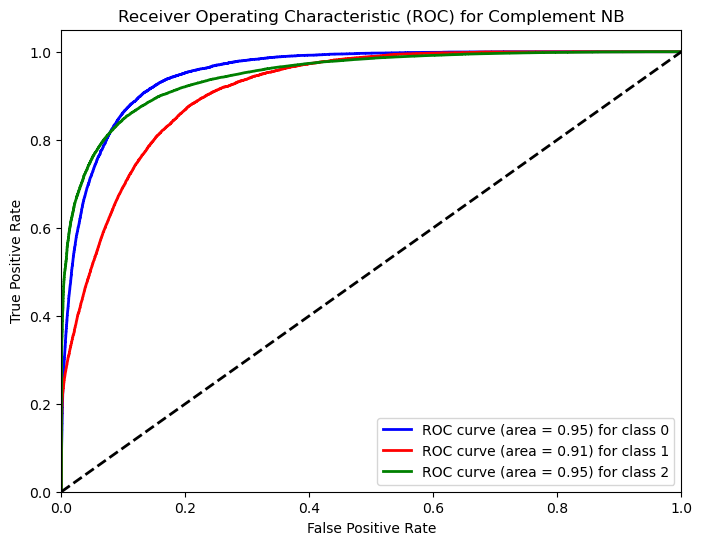

In [37]:
# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc_class = dict()
n_classes = y_test.nunique()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=[0, 1, 2])[:, i], y_pred_prob_test[:, i])
    roc_auc_class[i] = roc_auc_score(label_binarize(y_test, classes=[0, 1, 2])[:, i], y_pred_prob_test[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = %0.2f) for class %s' % (roc_auc_class[i], i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Complement NB')
plt.legend(loc="lower right")
plt.show()


In [38]:
# Predict classes on testing set
y_pred = mnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.60      0.61     11371
           1       0.56      0.43      0.49     12696
           2       0.95      0.97      0.96    181685

    accuracy                           0.92    205752
   macro avg       0.71      0.67      0.68    205752
weighted avg       0.91      0.92      0.91    205752



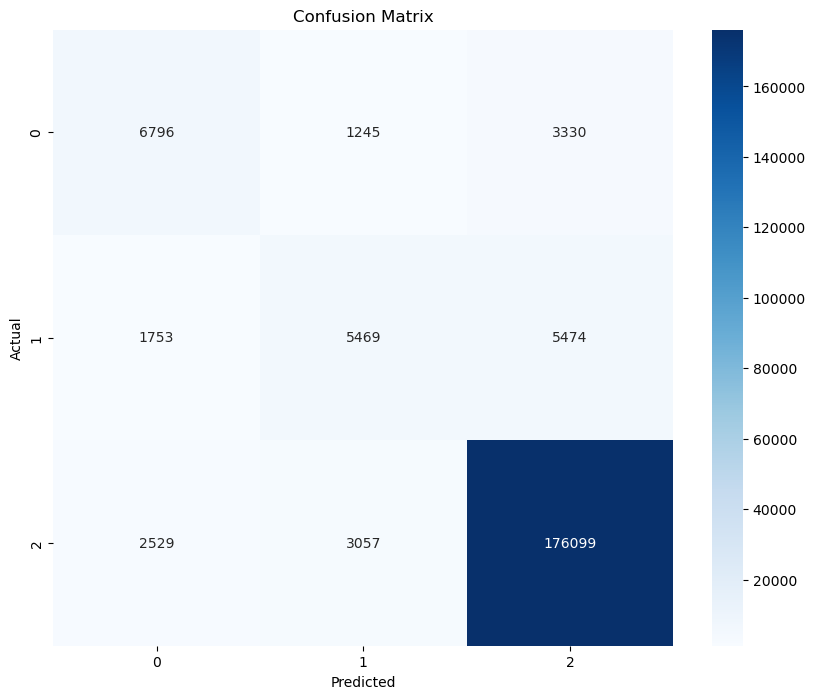

In [39]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=range(n_classes), yticklabels=range(n_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()